# Telecommunications Delinquency: Anomaly Detection Using Autoencoders 

_by Christian Alfred Soriano_



Delinquency is a condition that arises when activity or situation does not occur on its scheduled date, i.e. later than expected. A Microfinance Institution (MFI) provides micro-credit on mobile balances to be paid back in 5 days. If the consumer cannot pay within 5 days, this is considered delinquent behavior. Today, microfinance is widely accepted as a poverty-reduction tool, representing $70 billion in outstanding loans and a global outreach of 200 million clients and therefore detecting delinquencies is a must. _How might we improve days receivable to determine delinquency in MFI customers?_

## Novelty Detection
An outlier is a data point that is significantly different from the remaining data. It deviates so much from the other observations that it might be generated by a different mechanism. This is an important way to define outliers specifically  for autoencoders. In outlier analysis, we have two ways to detect outliers. We'll be focusing on **novelty detection** to identify future outliers. We often assign a score a data point which measures their 'outlierness'.

## Autoencoders
<img src='autoencoder.png'>
The autoencoder is semi-supervised, meaning the training set contains only normal data and the test set contains all anomalous data. It is a neural network that attempts to encode the data by compressing it into the lower dimensions using the bottleneck layer or code layer and then decoding the data to reconstruct the original input. The reconstructed input is then compared to the input and this difference is considered the **reconstructed loss** which is this method's measurement of 'outlierness'. The common measure used is _mean squared error_ shown below.

$$L = ||x - f(g(x))||^2$$


The bottleneck or code layer holds the compressed representation of the input data known as a latent space representation. The number of hidden units in the code is called code size.

We expect that when you run outliers through the autoencoder, they will have a high reconstruction loss since they are very different from what the model is trained on which is purely inliers. Inliers on the other hand, would have a low reconstruction loss when passed through the model.

## Import Libraries

In [1]:
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats

from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.metrics import confusion_matrix, classification_report, recall_score

from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Model

import lime
from lime import lime_tabular

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-d3atkroi because the default path (/home/casoriano/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Load Data

There are a total of 166738 unique users.

In [2]:
# read data
data = pd.read_csv('data.csv', parse_dates=['pdate']).drop('pcircle', axis=1)

# select only unique users
data = data.groupby('msisdn').max()

# convert time to hours
data['pdate'] = data['pdate'] - data['pdate'].min()
data['pdate'] = data['pdate'] / np.timedelta64(1, 'D')

# pre-filtering steps
data = data[(data['aon'] >= 0) & (data['aon'] < 500000) &
            (data['last_rech_date_ma'] < 200) & (data['last_rech_date_da'] < 150) &
            (data['fr_ma_rech30'] <= 100) & (data['cnt_da_rech30'] < 100) &
            (data['fr_da_rech30'] <= 100) & (data['maxamnt_loans30'] < 100) &
            (data['cnt_loans90'] < 100) & (data['maxamnt_loans30'] < 100)]
data = data[data >= 0].dropna(axis=0)

data = data.sort_values('pdate', kind='mergesort')
data

,label,aon,daily_decr30,daily_decr90,rental30,rental90,last_rech_date_ma,last_rech_date_da,last_rech_amt_ma,cnt_ma_rech30,...,amnt_loans30,maxamnt_loans30,medianamnt_loans30,cnt_loans90,amnt_loans90,maxamnt_loans90,medianamnt_loans90,payback30,payback90,pdate
msisdn,,,,,,,,,,,,,,,,,,,,,
00021I82735,1,1182.0,1.061667,1.061667,36.91,36.91,2.0,0.0,773,1,...,6,6.0,1.0,1.0,6,6,1.0,0.0,0.000000,0.0
00072I70376,1,223.0,1.781000,1.781000,102.61,102.61,2.0,0.0,2320,1,...,6,6.0,0.0,1.0,6,6,0.0,0.0,0.000000,0.0
00134I82730,0,1512.0,0.022333,0.022333,82.61,82.61,5.0,0.0,2320,1,...,6,6.0,0.0,1.0,6,6,0.0,0.0,0.000000,0.0
00248I84457,1,974.0,3.566667,3.566667,100.10,100.10,3.0,0.0,1547,3,...,12,6.0,0.0,2.0,12,6,0.0,0.0,0.000000,0.0
00449I85349,1,864.0,3.649667,3.649667,128.51,128.51,3.0,0.0,1547,3,...,12,6.0,0.0,2.0,12,6,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99813I82739,1,92.0,2660.000000,8325.340000,99.56,4536.24,29.0,0.0,770,1,...,12,12.0,0.0,1.0,12,12,0.0,0.0,0.000000,337.0
99905I90583,1,1086.0,7228.000000,9981.580000,4191.82,5308.15,1.0,0.0,1539,4,...,6,6.0,0.0,6.0,36,6,0.0,14.5,9.000000,337.0
99939I90841,1,933.0,9797.500000,13115.840000,8787.68,13868.68,2.0,0.0,770,7,...,30,6.0,0.0,9.0,54,6,0.0,5.0,7.888889,337.0


### Data Dictionary from Data Source

We see that there are 33 features in the dataset. The dataset is from Indonesia since the currency is in Indonesian Rupiah.

| Variable | Definition |
| --- | ----------- |
| label | Flag indicating whether the user paid back the credit amount within 5 days of issuing the loan {1:success, 0:failure} |
| msisdn | mobile number of user |
| aon | age on cellular network in days | |
| daily_decr30 | Daily amount spent from main account, averaged over last 30 days (in Indonesian Rupiah) |
| daily_decr90 | Daily amount spent from main account, averaged over last 90 days (in Indonesian Rupiah) |
| rental30 | Average main account balance over last 30 days |
| rental90 | Average main account balance over last 90 days |
| last_rech_date_ma | Number of days till last recharge of main account |
| last_rech_date_da | Number of days till last recharge of data account |
| last_rech_amt_ma | Amount of last recharge of main account (in Indonesian Rupiah) |
| cnt_ma_rech30 | Number of times main account got recharged in last 30 days |
| fr_ma_rech30 | Frequency of main account recharged in last 30 days |
| sumamnt_ma_rech30 | Total amount of recharge in main account over last 30 days (in Indonesian Rupiah) |
| medianamnt_ma_rech30 | Median of amount of recharges done in main account over last 30 days at user level (in Indonesian Rupiah) |
| medianmarechprebal30 | Median of main account balance just before recharge in last 30 days at user level (in Indonesian Rupiah) |
| cnt_ma_rech90 | Number of times main account got recharged in last 90 days |
| fr_ma_rech90 | Frequency of main account recharged in last 90 days |
| sumamnt_ma_rech90 | Total amount of recharge in main account over last 90 days (in Indonesian Rupiah) |
| medianamnt_ma_rech90 | Median of amount of recharges done in main account over last 90 days at user level (in Indonesian Rupiah) |
| medianmarechprebal90 | Median of main account balance just before recharge in last 90 days at user level (in Indonesian Rupiah) |
| cnt_da_rech30 | Number of times data account got recharged in last 30 days |
| fr_da_rech30 | Frequency of data account recharged in last 30 days |
| cnt_da_rech90 | Number of times data account got recharged in last 90 days |
| fr_da_rech90 | Frequency of data account recharged in last 90 days |
| cnt_loans30 | Number of loans taken by user in last 30 days |
| amnt_loans30 | Total amount of loans taken by user in last 30 days |
| maxamnt_loans30 | maximum amount of loan taken by the user in last 30 days |
| medianamnt_loans30 | Median of amounts of loan taken by the user in last 30 days |
| cnt_loans90 | Number of loans taken by user in last 90 days |
| amnt_loans90 | Total amount of loans taken by user in last 90 days |
| maxamnt_loans90 | maximum amount of loan taken by the user in last 90 days |
| medianamnt_loans90 | Median of amounts of loan taken by the user in last 90 days |
| payback30 | Average payback time in days over last 30 days |
| payback90 | Average payback time in days over last 90 days |
| pcircle | telecom circle |
| pdate | date |

## Exploratory Data Analysis (EDA)

#### Summary Statistics

In [3]:
data.describe().iloc[:, :11]

,label,aon,daily_decr30,daily_decr90,rental30,rental90,last_rech_date_ma,last_rech_date_da,last_rech_amt_ma,cnt_ma_rech30,fr_ma_rech30
count,166738.000000,166738.000000,166738.000000,166738.000000,166738.000000,166738.000000,166738.000000,166738.000000,166738.000000,166738.000000,166738.000000
mean,0.869472,655.498369,5752.634714,6537.766891,2911.386577,3782.855661,6.648910,1.039937,2087.829733,3.900557,4.119913
std,0.336885,496.483209,9428.873152,11245.775774,4470.430544,5987.626055,9.707988,7.455402,2351.451964,4.144893,5.512605
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,244.000000,47.938750,48.252333,334.405000,390.000000,1.000000,0.000000,770.000000,1.000000,0.000000
50%,1.000000,519.000000,2000.000000,2046.395000,1227.300000,1548.520000,3.000000,0.000000,1539.000000,3.000000,2.000000
75%,1.000000,960.000000,7862.087250,8567.357500,3684.122500,4585.767500,8.000000,0.000000,2309.000000,5.000000,6.000000
max,1.000000,2440.000000,265926.000000,320630.000000,198926.110000,200148.110000,113.000000,115.000000,55000.000000,203.000000,38.000000


In [4]:
data.describe().iloc[:, 11:21]

,sumamnt_ma_rech30,medianamnt_ma_rech30,medianmarechprebal30,cnt_ma_rech90,fr_ma_rech90,sumamnt_ma_rech90,medianamnt_ma_rech90,medianmarechprebal90,cnt_da_rech30,fr_da_rech30
count,166738.000000,166738.000000,166738.00000,166738.000000,166738.000000,166738.000000,166738.000000,166738.000000,166738.000000,166738.000000
mean,7516.524967,1812.324785,4255.32518,6.271906,8.145408,12312.898212,1858.541475,97.283954,0.026143,0.021309
std,9632.746554,2037.816139,56791.43888,7.079982,12.837153,16579.171893,2041.590160,374.202268,0.290686,0.482847
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1540.000000,770.000000,12.00000,2.000000,0.000000,2316.000000,773.000000,15.500000,0.000000,0.000000
50%,4622.000000,1539.000000,37.17000,4.000000,3.000000,7127.000000,1539.000000,38.500000,0.000000,0.000000
75%,10000.000000,1924.000000,87.67000,8.000000,9.000000,16000.000000,1924.000000,82.330000,0.000000,0.000000
max,275010.000000,55000.000000,999479.41930,336.000000,88.000000,418133.000000,55000.000000,41456.500000,34.000000,25.000000


In [5]:
data.describe().iloc[:, 21:]

,cnt_da_rech90,fr_da_rech90,cnt_loans30,amnt_loans30,maxamnt_loans30,medianamnt_loans30,cnt_loans90,amnt_loans90,maxamnt_loans90,medianamnt_loans90,payback30,payback90,pdate
count,166738.000000,166738.000000,166738.000000,166738.000000,166738.000000,166738.000000,166738.000000,166738.000000,166738.000000,166738.000000,166738.000000,166738.000000,166738.000000
mean,0.046732,0.051806,2.681230,17.543895,6.710804,0.059363,3.621898,23.310247,6.759347,0.050240,3.604793,4.610274,184.308784
std,0.430977,0.987099,2.459381,16.870776,2.241228,0.228759,3.914319,25.890470,2.188019,0.209736,9.291319,10.871056,72.249782
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,6.000000,6.000000,0.000000,1.000000,6.000000,6.000000,0.000000,0.000000,0.000000,162.000000
50%,0.000000,0.000000,2.000000,12.000000,6.000000,0.000000,2.000000,12.000000,6.000000,0.000000,0.000000,1.666667,191.000000
75%,0.000000,0.000000,3.000000,24.000000,6.000000,0.000000,5.000000,30.000000,6.000000,0.000000,4.000000,4.818182,215.000000
max,38.000000,64.000000,50.000000,300.000000,12.000000,3.000000,71.000000,438.000000,12.000000,3.000000,171.500000,171.500000,337.000000


In [6]:
# all values are now int or float

data.dtypes

label                     int64
aon                     float64
daily_decr30            float64
daily_decr90            float64
rental30                float64
rental90                float64
last_rech_date_ma       float64
last_rech_date_da       float64
last_rech_amt_ma          int64
cnt_ma_rech30             int64
fr_ma_rech30            float64
sumamnt_ma_rech30       float64
medianamnt_ma_rech30    float64
medianmarechprebal30    float64
cnt_ma_rech90             int64
fr_ma_rech90              int64
sumamnt_ma_rech90         int64
medianamnt_ma_rech90    float64
medianmarechprebal90    float64
cnt_da_rech30           float64
fr_da_rech30            float64
cnt_da_rech90             int64
fr_da_rech90              int64
cnt_loans30               int64
amnt_loans30              int64
maxamnt_loans30         float64
medianamnt_loans30      float64
cnt_loans90             float64
amnt_loans90              int64
maxamnt_loans90           int64
medianamnt_loans90      float64
payback3

In [7]:
# thankfully there are no null values

data.isnull().sum()

label                   0
aon                     0
daily_decr30            0
daily_decr90            0
rental30                0
rental90                0
last_rech_date_ma       0
last_rech_date_da       0
last_rech_amt_ma        0
cnt_ma_rech30           0
fr_ma_rech30            0
sumamnt_ma_rech30       0
medianamnt_ma_rech30    0
medianmarechprebal30    0
cnt_ma_rech90           0
fr_ma_rech90            0
sumamnt_ma_rech90       0
medianamnt_ma_rech90    0
medianmarechprebal90    0
cnt_da_rech30           0
fr_da_rech30            0
cnt_da_rech90           0
fr_da_rech90            0
cnt_loans30             0
amnt_loans30            0
maxamnt_loans30         0
medianamnt_loans30      0
cnt_loans90             0
amnt_loans90            0
maxamnt_loans90         0
medianamnt_loans90      0
payback30               0
payback90               0
pdate                   0
dtype: int64

## Preprocess Data

### Divide data into inliers and outliers

Of the 166738 users, 15.012% or 21764 are considered to be delinquents.

In [8]:
inliers = data[data['label'] == 1].drop('label', axis=1)
outliers = data[data['label'] == 0].drop('label', axis=1)
columns = data.drop('label', axis=1).columns
ratio = len(outliers)/len(inliers)

print('Percentage of Outliers: {:.3f}%'.format(ratio*100))
inliers.shape, outliers.shape

Percentage of Outliers: 15.012%


((144974, 33), (21764, 33))

Here we visualize the inliers and outliers in the TSNE space. We see that the separation boundary between the two is not any defined function therefore using autoencoders may give better results than other methods such a linear decision boundary classification model.

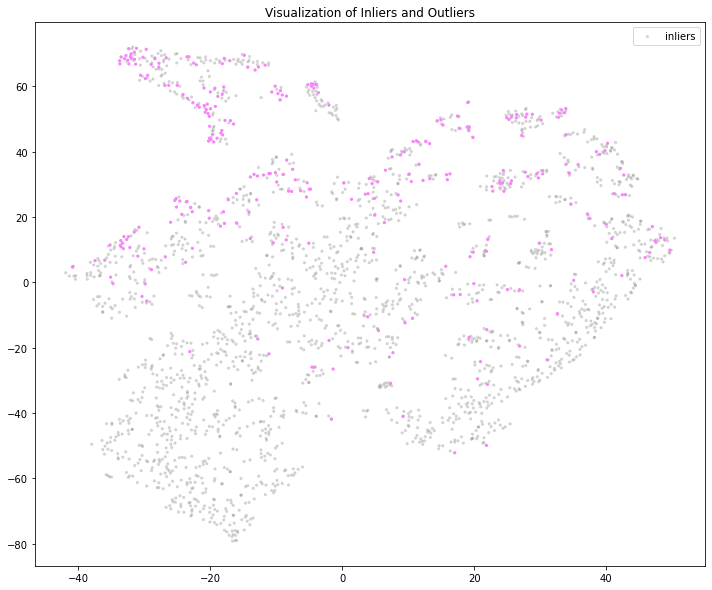

In [9]:
n_samples = 2000
inliers_sample = inliers.sample(n_samples, random_state=0)
outliers_sample = outliers.sample(round(n_samples*ratio), random_state=0)

sample = inliers_sample.append(outliers_sample)
sample_embedded = TSNE(n_components=2, n_jobs=-1).fit_transform(sample)
sample_y = data['label'].loc[sample.index]

plt.figure(figsize=(12, 10))
plt.scatter(sample_embedded[:, 0], sample_embedded[:, 1], 
            c=sample_y.map({1: 'grey', 0: '#F884FA'}), s=5.,
            alpha=sample_y.map({1: 0.25, 0: 1}), label='inliers')
plt.title('Visualization of Inliers and Outliers')
plt.legend()
plt.show()

Below, we see the distributions of inliers colored as gray compared to outliers colored as pink for every feature. It would be a valid method to reduce the number of features based on how similar the distributions are for inliers and outliers.

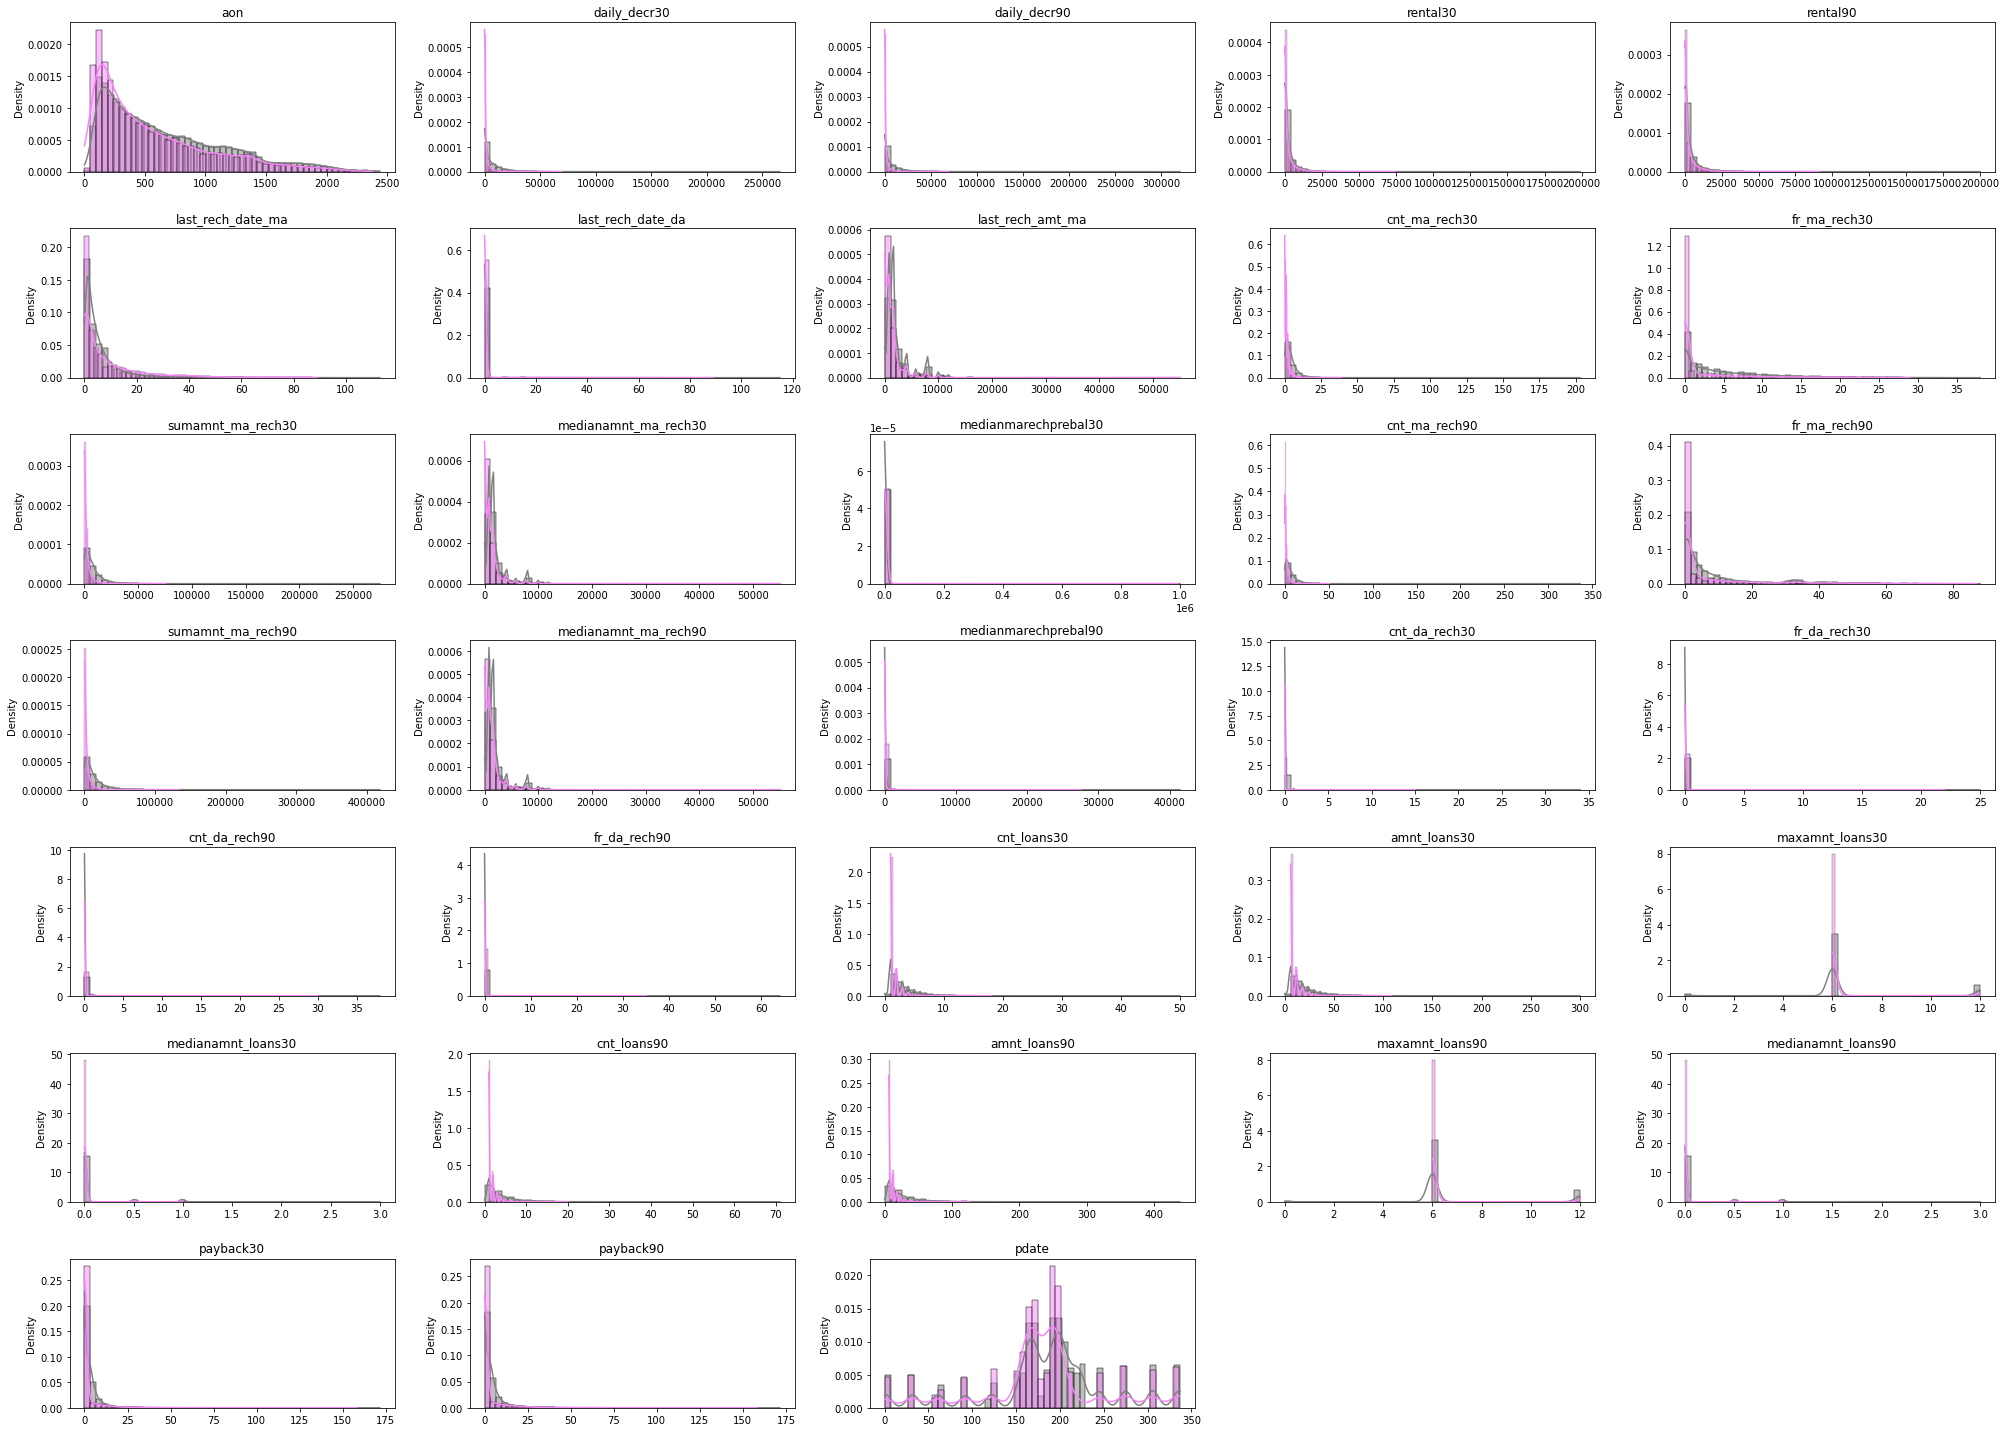

In [10]:
grid = gridspec.GridSpec(7, 5)
plt.figure(figsize=(28, 20))
plt.title('Distribution of Inlier and Outlier Distriubtions for Every Feature')

for n, col in enumerate(data[columns]):
    ax = plt.subplot(grid[n])
    sns.histplot(inliers[col], bins=50, color='gray',
                 stat='density', kde=True)
    sns.histplot(outliers[col], bins=50, color='#F884FA',
                 stat='density', kde=True)
    ax.set_title(str(col))
    ax.set_xlabel('')
    
plt.tight_layout()
plt.show()

Below we see that only 31 of the features have a inlier-outlier significantly different from each other. However, since this does not reduce our features that much, we can keep all features for now.

In [11]:
columns_sig = [i for i in columns
               if stats.mannwhitneyu(inliers[i], outliers[i])[1] < 0.001]
print('List of features with significantly different at 0.001 inlier and outlier distributions:')
columns_sig

List of features with significantly different at 0.001 inlier and outlier distributions:


['aon',
 'daily_decr30',
 'daily_decr90',
 'rental30',
 'rental90',
 'last_rech_date_ma',
 'last_rech_date_da',
 'last_rech_amt_ma',
 'cnt_ma_rech30',
 'fr_ma_rech30',
 'sumamnt_ma_rech30',
 'medianamnt_ma_rech30',
 'medianmarechprebal30',
 'cnt_ma_rech90',
 'fr_ma_rech90',
 'sumamnt_ma_rech90',
 'medianamnt_ma_rech90',
 'medianmarechprebal90',
 'cnt_da_rech30',
 'cnt_da_rech90',
 'cnt_loans30',
 'amnt_loans30',
 'maxamnt_loans30',
 'medianamnt_loans30',
 'cnt_loans90',
 'amnt_loans90',
 'maxamnt_loans90',
 'medianamnt_loans90',
 'payback30',
 'payback90',
 'pdate']

### Divide data into Train, Validation and Test

We use a random seed to create a random division between the train, validation and test sets. The train set contains only inliers. The test set contains all outliers. It also contains inliers with only 1/5 of the size of outliers. The validation set is 1/20 of the train set size.

In [12]:
random.seed(42)

test_idx = random.sample(list(inliers.index), round(len(outliers)/5))
X_train = inliers.loc[inliers.index.drop(test_idx)]

val_idx = random.sample(list(X_train.index), round(len(X_train)/20))

X_val = X_train.loc[val_idx]
X_train = X_train.loc[X_train.index.drop(val_idx)]
X_test = inliers.loc[test_idx].append(outliers)

y_train = data['label'].loc[X_train.index]
y_val = data['label'].loc[X_val.index]
y_test = data['label'].loc[X_test.index]

print('Train:', X_train.shape, y_train.shape)
print('Validation:', X_val.shape, y_val.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (133590, 33) (133590,)
Validation: (7031, 33) (7031,)
Test: (26117, 33) (26117,)


### Scale data based on Train set

Scaling is only based on train set.

In [13]:
pipeline = Pipeline([('scaler', MinMaxScaler()),
                    ])
pipeline.fit(X_train)
X_train_transformed = pipeline.transform(X_train)
X_val_transformed = pipeline.transform(X_val)
X_test_transformed = pipeline.transform(X_test)

## The Autoencoder Model

Finally, we build our autoencoder model.

The optimizer used is `Adam`.
The loss is set to `mean squared error` since how our reconstructon loss will be calculated.

Neural networks are prone to overfitting. This is why the initial decode layer is set to have an activity regularizer to learn sparse feature representations and reduce overfitting. Apart from this, this approach also improves the model’s generalization ability to unseen data. 

The last layer activation function is set to sigmoid so that it matches the results of the MinMaxScaler.

Many iterations of the final model architecture have been created. Some hyperparameters tuned include:
1. **Number of hidden layers**\
The number of hidden layers in the final architecture is 3. 1, 2 and 4 layers were also tested however gave worse results.

2. **The size of hidden layers**\
For each number of hidden layers, a size of 2^n was assigned. The resulting network architecture should be symmetric with respect to the code layer. The values of the layers would have a maximum of

$$2^n <=  features, n = 0, 1, 2, ...$$

Since we have 33 features as input, the possible sizes of our hidden layers tested are 32, 16, 8, 4 and 2. We only have 1 - 4 layers as well which gives us

$$\sum^{x}_{n = layers}{5Cx}$$

combinations where n is the number of layers.

### Final Model Architecture

In [14]:
input_dim = X_train_transformed.shape[1]
inputs = layers.Input(shape=(input_dim, ))

# deconstruct / encode
x = layers.Dense(16, activation='relu', activity_regularizer=regularizers.l2(1e-7))(inputs)
x = layers.Dense(8, activation='relu')(x)
x = layers.Dense(4, activation='relu')(x)
    
# reconstruction / decode
x = layers.Dense(8, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dense(input_dim, activation='sigmoid')(x)

# Autoencoder
autoencoder = Model(inputs=inputs, outputs=x)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

2022-03-11 23:22:10.602127: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-11 23:22:40.904268: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9658 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:61:00.0, compute capability: 7.5


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 33)]              0         
_________________________________________________________________
dense (Dense)                (None, 16)                544       
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_4 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_5 (Dense)              (None, 33)                561   

The number of epochs was set to 64 with 3s per epoch. However, the losses are very small after the first epoch.

In [15]:
BATCH_SIZE = 256
EPOCHS = 64

history = autoencoder.fit(
            x=X_train_transformed,
            y=y_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            shuffle=True,
            verbose=1,
            validation_data=(X_val_transformed, y_val),
            )

2022-03-11 23:22:41.997362: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/64
522/522 [==============================] - 5s 6ms/step - loss: 0.0299 - val_loss: 2.7435e-05
Epoch 2/64
522/522 [==============================] - 3s 6ms/step - loss: 1.2570e-05 - val_loss: 6.2655e-06
Epoch 3/64
522/522 [==============================] - 3s 6ms/step - loss: 4.2861e-06 - val_loss: 3.1670e-06
Epoch 4/64
522/522 [==============================] - 3s 6ms/step - loss: 2.5375e-06 - val_loss: 2.1729e-06
Epoch 5/64
522/522 [==============================] - 3s 6ms/step - loss: 1.8934e-06 - val_loss: 1.7412e-06
Epoch 6/64
522/522 [==============================] - 3s 6ms/step - loss: 1.5930e-06 - val_loss: 1.5194e-06
Epoch 7/64
522/522 [==============================] - 3s 6ms/step - loss: 1.4308e-06 - val_loss: 1.3907e-06
Epoch 8/64
522/522 [==============================] - 3s 6ms/step - loss: 1.3323e-06 - val_loss: 1.3070e-06
Epoch 9/64
522/522 [==============================] - 3s 6ms/step - loss: 1.2648e-06 - val_loss: 1.2455e-06
Epoch 10/64
522/522 [===========

#### Plotting the History Points

We do not see any overfitting since the difference between train loss and val loss is small.

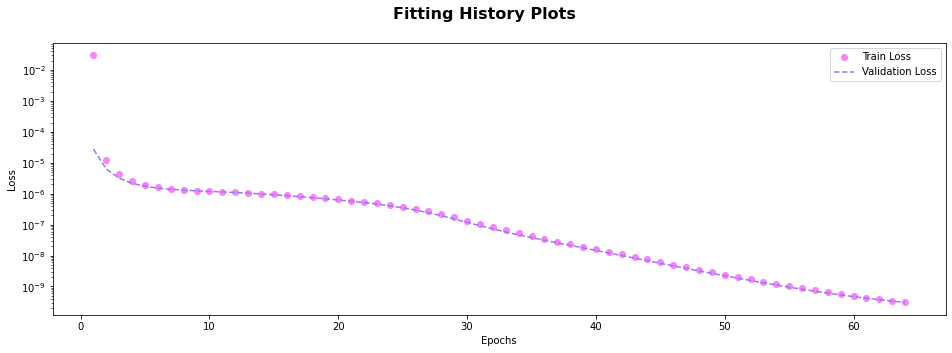

In [16]:
def plot_history(history):
    """Get metrics and losses from history object"""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Generate epoch number list
    epochs = range(1, EPOCHS+1)

    # Initialize figure
    fig, ax = plt.subplots(figsize=(16, 5))

    # Plot epochs and metrics/loss values
    ax.plot(epochs, loss, 'o', color='#F884FA', label='Train Loss')
    ax.plot(epochs, val_loss, '--', color='#9976FF',
                 label='Validation Loss')

    # Add axis labels and legends
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_yscale("log")
    ax.legend()
    fig.suptitle("Fitting History Plots", fontsize=16, weight='bold')

    return fig, ax

plot_history(history);

## Model Evaluation

We now use the reconstruction loss of the test set and their ground truth labels to determine a threshold loss that defines outliers. The threshold here is defined at **L = 0.885**.

In [17]:
def reconstruction_loss(test, truth):
    """Determine MSE reconstruciton loss."""
    return np.mean(np.power(test - truth, 2), axis=1)

X_pred = autoencoder.predict(X_test_transformed)
mse = reconstruction_loss(X_test_transformed, X_pred)

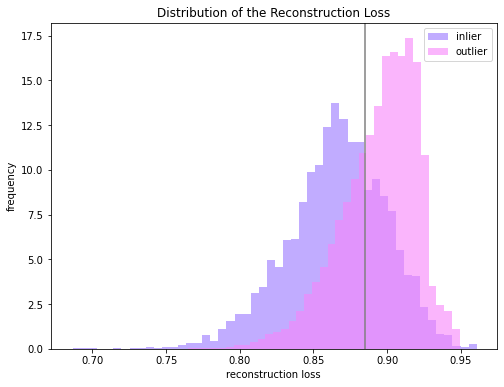

In [18]:
# plotting the reconstruction loss distributions based on labels

fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(mse[(y_test == 1).values], bins=50, density=True,
        alpha=.6, color='#9976FF', label='inlier')
ax.hist(mse[(y_test == 0).values], bins=50, density=True,
        alpha=.6, color='#F884FA', label='outlier')
ax.axvline(0.885, color='grey')

plt.title("Distribution of the Reconstruction Loss")
plt.xlabel('reconstruction loss')
plt.ylabel('frequency')
plt.legend()
plt.show()

#### Evaluation Metrics

We now check the accuracy, precision, recall and F1-score by setting all values above the threshold L as an outlier. We use _recall_ because we want to minimize all delinquent behavior. We get a recall of 0.69 using the autoencoder model.

In [19]:
# print the evaluation metrics

print(confusion_matrix((mse > 0.885) * 1, y_test))
print(classification_report((mse > 0.885) * 1, y_test))

[[ 6809  3098]
 [14955  1255]]
              precision    recall  f1-score   support

           0       0.31      0.69      0.43      9907
           1       0.29      0.08      0.12     16210

    accuracy                           0.31     26117
   macro avg       0.30      0.38      0.28     26117
weighted avg       0.30      0.31      0.24     26117



## Comparison to Other Anomaly Detection Models

We use the models below to compare to the autoencoder model. We set the contamination to the same percentage of outliers as of that of the dataset.

In [49]:
cont = len(outliers)/len(inliers) if len(outliers)/len(inliers) > 0.1 else 0.1

### Local Outlier Factor

In [51]:
start = time.time()

k = 20
lof = LocalOutlierFactor(n_neighbors=k, contamination=cont, novelty=True, n_jobs=-1)
lof.fit(X_train_transformed)
pred_lof = lof.predict(X_test_transformed)
lof_time = time.time() - start

print('Run time:', lof_time)
print(confusion_matrix(y_test.replace({0: -1}), pred_lof))
print(classification_report(y_test.replace({0: -1}), pred_lof))

Run time: 1215.8889155387878
[[ 2797 18967]
 [  664  3689]]
              precision    recall  f1-score   support

          -1       0.81      0.13      0.22     21764
           1       0.16      0.85      0.27      4353

    accuracy                           0.25     26117
   macro avg       0.49      0.49      0.25     26117
weighted avg       0.70      0.25      0.23     26117



### Isolation Forest

In [52]:
start = time.time()

IF = IsolationForest(n_estimators=200, contamination=cont, random_state=42, n_jobs=-1)
IF.fit(X_train_transformed)
pred_IF = IF.predict(X_test_transformed)
if_time = time.time() - start

print('Run time:', if_time)
print(confusion_matrix(y_test.replace({0: -1}), pred_IF))
print(classification_report(y_test.replace({0: -1}), pred_IF))

Run time: 12.291007041931152
[[  802 20962]
 [  661  3692]]
              precision    recall  f1-score   support

          -1       0.55      0.04      0.07     21764
           1       0.15      0.85      0.25      4353

    accuracy                           0.17     26117
   macro avg       0.35      0.44      0.16     26117
weighted avg       0.48      0.17      0.10     26117



### One-Class SVM

In [58]:
start = time.time()

ocsvm = OneClassSVM(nu=0.008, kernel='rbf')
ocsvm.fit(X_train_transformed)
pred_ocsvm = ocsvm.predict(X_test_transformed)
ocsvm_time = time.time() - start

print('Run time:', ocsvm_time)
print(confusion_matrix(y_test.replace({0: -1}), pred_ocsvm))
print(classification_report(y_test.replace({0: -1}), pred_ocsvm))

Run time: 122.50149512290955
[[   82 21682]
 [   35  4318]]
              precision    recall  f1-score   support

          -1       0.70      0.00      0.01     21764
           1       0.17      0.99      0.28      4353

    accuracy                           0.17     26117
   macro avg       0.43      0.50      0.15     26117
weighted avg       0.61      0.17      0.05     26117



As we can see below, the best model in terms of recall is the autoencoder. However, it is thrid in run time but given that it is only 200s, this is already a good trade off compared to the 2nd best model of LOF where it is only 0.13 for recall but takes about 20 minutes to run.

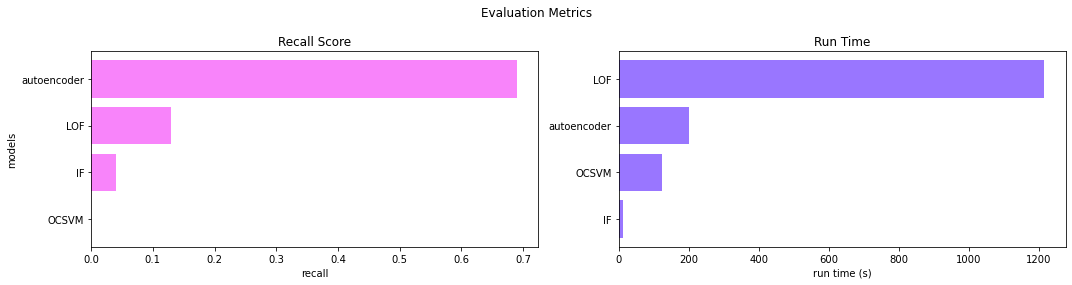

In [20]:
labels = ['autoencoder', 'LOF', 'IF', 'OCSVM']
recall = [0.69, 0.13, 0.04, 0.00]
run_time = [200.02, 1215.89, 12.29, 122.50]

fig, ax = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Evaluation Metrics')

ax[0].barh(labels, recall, color='#F884FA')
ax[0].set_title('Recall Score')
ax[0].set_xlabel('recall')
ax[0].set_ylabel('models')
ax[0].invert_yaxis()

ax[1].barh([x for x, y in sorted(zip(labels, run_time), key=lambda x: -x[1])],
           [y for x, y in sorted(zip(labels, run_time), key=lambda x: -x[1])],
           color='#9976FF')
ax[1].set_title('Run Time')
ax[1].set_xlabel('run time (s)')
ax[1].invert_yaxis()

plt.tight_layout()
plt.show()

## Explainability

With the advancements in explainability such as SHAP and LIME, we can now explain how the outliers were determined. This is possible due to the simple architecture of the autoencoder model. This is one of the advantages of the autoencoder versus other anomaly detection models.

Below we see that the data point is an outlier and what makes it an outlier is the frequency of their main account being recharged in last 30 days and 90 days. Therefore, the MSI can create certain an alert that detects this threshold and send a reminder to the possible delinquent customer to pay their loans.

In [22]:
threshold = 0.885
inlier_std = np.std(mse[y_test == 0], ddof=1)
outlier_std = np.std(mse[y_test == 1], ddof=1)

def predict_lime(x):
    """Predictor to be used in Lime."""
    lst = []
    for i in np.mean(np.power(x - autoencoder.predict(x), 2), axis=1):
        p_in = stats.norm.sf(abs((i - threshold) / inlier_std))
        p_out = stats.norm.sf(abs((i - threshold) / outlier_std)) + 0.00001
        lst.append([p_out/(p_in + p_out), p_in/(p_in + p_out)])
    return np.array(lst)

explainer = lime.lime_tabular.LimeTabularExplainer(
    X_test_transformed, feature_names=X_test.columns,
    class_names=['outlier', 'inlier'], kernel_width=5)
exp = explainer.explain_instance(X_test_transformed[-1, :], predict_lime,
                                 num_features=10)
exp.show_in_notebook(show_all=False)

## Conclusions and Insights

1. Autoencoders can work better than other anomaly detection models depending on the use case. In this case, in terms of telecommunications delinquency, we have a really good recall score for the model.

2. In terms of run time, the autoencoder is also faster than the second best model in terms of recall. Also for LOF, the larger the number of neighbors, the better it performs at the cost of run time.

3. Autoencoders also prefer high dimensional data since it compresses this in a latent space representation capturing only the most important parts. This can be problematic for other models since it would take longer run times.

4. Autoencoders can predict outliers even if decision boundaries are not linear such as that seen above.

5. Because it is a semi-supervised model, the methodology can work even though the dataset is highly imbalanced. No resampling techniques are needed in the pipeline.

6. Lastly, due to the simpler architecture of autoencoders, they can now be used with explainability libraries. Therefore, we can determine what makes delinquent behavior.

## Recommendations

1. More hyperparameter tuning for all models can still be done to achieve better results.

2. Comparison with classification models with resampling for imbalance can be done.

3. Statistical methods can be used to determine the best threshold between the inlier and outlier histograms.

Overall, autoencoders are a fast and simple way of determining anomalies and can be continuously kept and retrained without having to use too much resources due to complexity.

## References

 Lendave, V. (2021, December 1). What is activity regularization in neural networks? Analytics India Magazine. Retrieved March 11, 2022, from https://analyticsindiamag.com/what-is-activity-regularization-in-neural-networks/ 
 
Bandyopadhyay, H. (n.d.). An introduction to autoencoders: Everything you need to know. An Introduction to Autoencoders: Everything You Need to Know. Retrieved March 11, 2022, from https://www.v7labs.com/blog/autoencoders-guide 

Chollet, F. (n.d.). The keras blog. The Keras Blog ATOM. Retrieved March 11, 2022, from https://blog.keras.io/building-autoencoders-in-keras.html 

Dertat, A. (2017, October 8). Applied deep learning - part 3: Autoencoders. Medium. Retrieved March 11, 2022, from https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798 

Intro to autoencoders &nbsp;: &nbsp; Tensorflow Core. TensorFlow. (n.d.). Retrieved March 11, 2022, from https://www.tensorflow.org/tutorials/generative/autoencoder 

Jordan, J. (2018, March 19). Introduction to autoencoders. Jeremy Jordan. Retrieved March 11, 2022, from https://www.jeremyjordan.me/autoencoders/ 

Krishna, S. V. S. (2020, May 14). Delinquency telecom dataset. Kaggle. Retrieved March 11, 2022, from https://www.kaggle.com/sivakrishna3311/delinquency-telecom-dataset 

Pradeepvats. (2019, July 16). Project: Delinquency telecom model. Data Science, Analytics and Big Data discussions. Retrieved March 11, 2022, from https://discuss.analyticsvidhya.com/t/project-delinquency-telecom-model/82924 